In [32]:
import numpy as np
import math
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import glob
import os

In [33]:
pd.set_option('display.max_rows', 100)

In [34]:
def name_to_index(name):
    return name.split("_")[1]

def index_to_name(index):
    return "im_"+str(int(index))

def file_path_to_name(path):
    return os.path.splitext(os.path.basename(path))[0] 
print(name_to_index("im_1"))

print(index_to_name(1))

1
im_1


In [35]:
def load_label_dfs():
    i = 0
    last_seq = 0
    for file in glob.glob("data/dfs/*.csv"):
        if i == 0:
            df = pd.read_csv(file, skiprows=0).iloc[:, 1:]
            last_seq = df.tail(1)['video_seq'].values[0]
        else:
            new_df = pd.read_csv(file, skiprows=0).iloc[:, 1:]
            new_df.loc[:, 'video_seq'] += last_seq     
            last_seq = new_df.tail(1)['video_seq'].values[0]
            
            df = df.append(new_df, ignore_index = True)
        i += 1
    return df

df = load_label_dfs()
print(df)
print(df.shape)

       name   folder  video_seq  traction  \
0      im_1  images1          1         1   
1     im_16  images1          1         1   
2     im_31  images1          1         1   
3     im_46  images1          1         1   
4     im_61  images1          1         1   
..      ...      ...        ...       ...   
485  im_391  images8         12         1   
486  im_406  images8         12         1   
487  im_421  images8         12         1   
488  im_436  images8         12         1   
489  im_451  images8         12         1   

                                          barre  \
0     [0.4321705426356589, 0.31976744186046513]   
1    [0.42829457364341084, 0.31007751937984496]   
2        [0.436046511627907, 0.312015503875969]   
3    [0.43410852713178294, 0.28875968992248063]   
4    [0.43410852713178294, 0.29844961240310075]   
..                                          ...   
485  [0.47093023255813954, 0.14922480620155038]   
486   [0.47093023255813954, 0.1511627906976744]   


In [36]:
def correct_video_seqs(df):
    for curr_i in range(1,len(df)):
        curr_video_seq = df.video_seq.iloc[curr_i]
        if(df.video_seq.iloc[curr_i] == df.video_seq.iloc[curr_i - 1]):
            if(df.traction.iloc[curr_i] != df.traction.iloc[curr_i - 1]):
                df.video_seq.iloc[curr_i:] += 1 
    return(df)

In [37]:
df = correct_video_seqs(df)
l_video_seq = df.loc[:,'video_seq'].drop_duplicates()
print(l_video_seq)

0       1
22      2
69      3
99      4
100     5
126     6
209     7
250     8
259     9
263    10
290    11
295    12
314    13
317    14
344    15
378    16
412    17
436    18
459    19
Name: video_seq, dtype: int64


C:\Users\alexa\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


images1


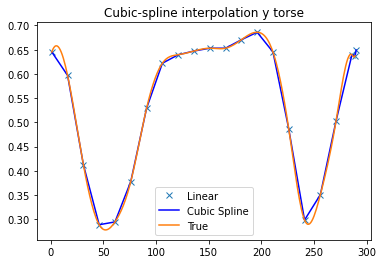

images1


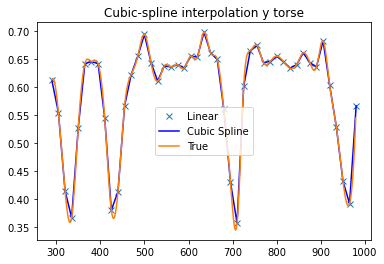

images1


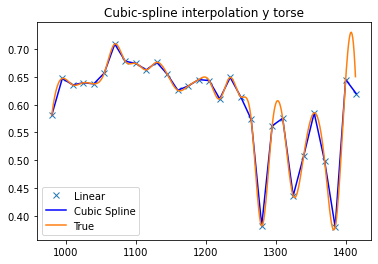

images1
images1


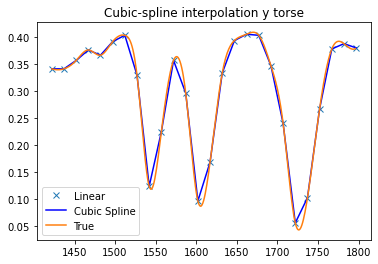

images1


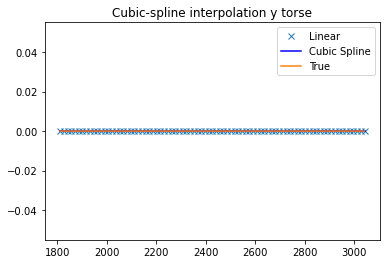

images1


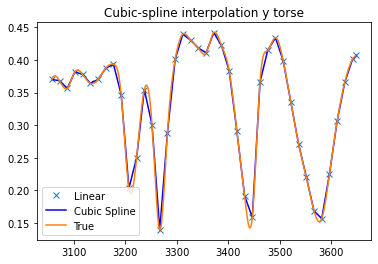

images1


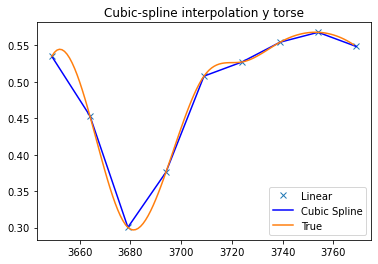

images2


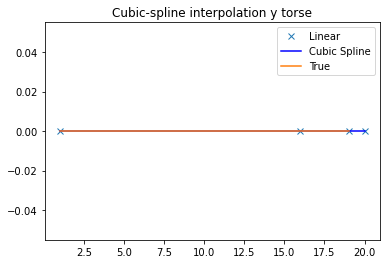

images2


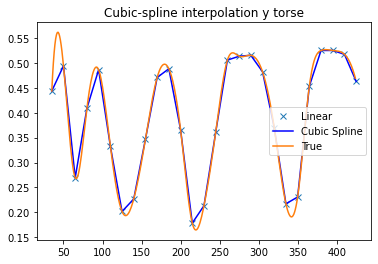

images2


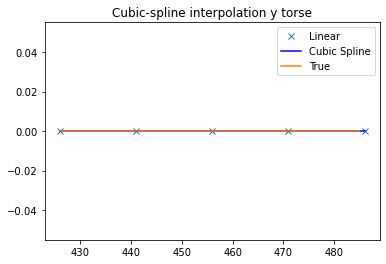

images2


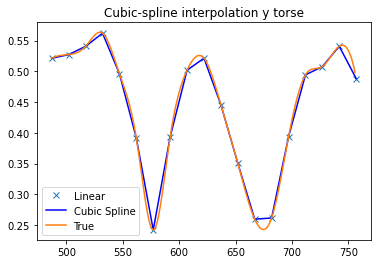

images2
images3


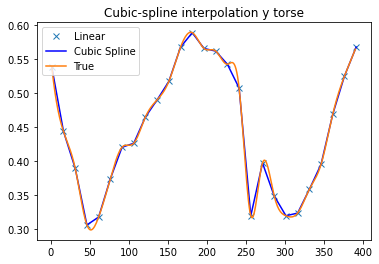

images4


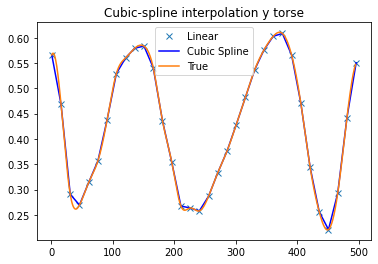

images5


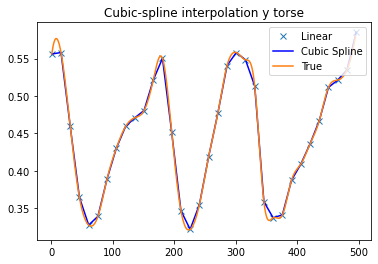

images6


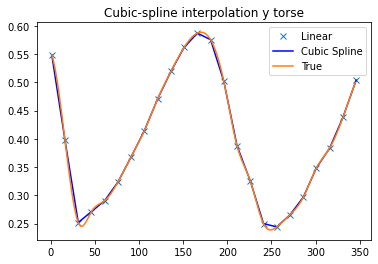

images7


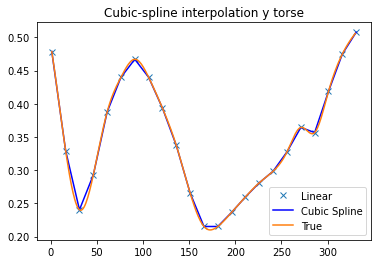

images8


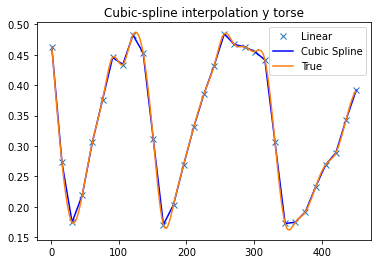

In [38]:
l = []
for i in range(len(l_video_seq)):
    mask = df.loc[:,'video_seq'] == l_video_seq.iloc[i]
    df_temp = df.copy().loc[mask]
    df_temp['x'] = df_temp.loc[:,'name'].apply(name_to_index)
    folder = df_temp.iloc[0,1]
    print(folder)
    x = [float(x) for x in df_temp.x]
    x_torse = [float(x[0]) for x in df_temp.torse.apply(lambda x:x[1:-1]).apply(lambda x:x.split(','))]
    y_torse = [float(x[1]) for x in df_temp.torse.apply(lambda x:x[1:-1]).apply(lambda x:x.split(','))]
    
    x_barre = [float(x[0]) for x in df_temp.barre.apply(lambda x:x[1:-1]).apply(lambda x:x.split(','))]
    y_barre = [float(x[1]) for x in df_temp.barre.apply(lambda x:x[1:-1]).apply(lambda x:x.split(','))]
    
    if len(x) > 3:        
        xnew = np.arange(min(x), max(x), 1)
        
        tck_x_torse = interpolate.splrep(x, x_torse, s=0)
        tck_y_torse = interpolate.splrep(x, y_torse, s=0)
        tck_x_barre = interpolate.splrep(x, x_barre, s=0)
        tck_y_barre = interpolate.splrep(x, y_barre, s=0)
        
        x_torse_new = interpolate.splev(xnew, tck_x_torse, der=0)
        y_torse_new = interpolate.splev(xnew, tck_y_torse, der=0)
        x_barre_new = interpolate.splev(xnew, tck_x_barre, der=0)
        y_barre_new = interpolate.splev(xnew, tck_y_barre, der=0)
        
        for j in range(len(xnew)):
            l.append({'name': index_to_name(xnew[j]),
                      'folder': folder,
                      'video_seq': l_video_seq.iloc[i],
                      'traction': 0 if (x_torse_new[j] == 0) & (y_torse_new[j] ==0) else 1,
                      'x_torse': x_torse_new[j],
                      'y_torse': y_torse_new[j],
                      'x_barre': x_barre_new[j],
                      'y_barre': y_barre_new[j],
            })
        
        plt.figure()
        plt.plot(x, y_torse, 'x', x, y_torse, 'b', xnew, y_torse_new)
        plt.legend(['Linear', 'Cubic Spline', 'True'])
        plt.title('Cubic-spline interpolation y torse')
        plt.show()        
    else:
        pass
full_df = pd.DataFrame(l)

In [39]:
full_df

,name,folder,video_seq,traction,x_torse,y_torse,x_barre,y_barre
0,im_1,images1,1,1,0.428295,0.645349,0.432171,0.319767
1,im_2,images1,1,1,0.424063,0.650734,0.430928,0.317383
2,im_3,images1,1,1,0.420557,0.654607,0.429866,0.315334
3,im_4,images1,1,1,0.417740,0.657033,0.428975,0.313602
4,im_5,images1,1,1,0.415576,0.658076,0.428246,0.312166
...,...,...,...,...,...,...,...,...
6970,im_446,images8,19,1,0.477824,0.380268,0.474181,0.151481
6971,im_447,images8,19,1,0.477209,0.383056,0.474054,0.151888
6972,im_448,images8,19,1,0.476418,0.385591,0.473864,0.152437
6973,im_449,images8,19,1,0.475438,0.387853,0.473606,0.153138


In [40]:
full_df2 = []
seq = max(full_df['video_seq']) + 1
#dossiers echantillons négatifs
for i in range(1,3):
    f_name = "only_not_hanging" + str(i)
    folder_path = "data/images/"+f_name
    files_path = folder_path+"/*.jpg"
    for file in glob.glob(files_path):
        full_df2.append({"name":file_path_to_name(file),
                      "folder":f_name,
                      "video_seq":seq,
                      "traction":0,
                      "x_torse":0,
                      "y_torse":0,
                      "x_barre":0,
                      "y_barre":0})
    seq+=1
    
#dossiers echantillons positifs non annotés
for i in range(9,14):
    f_name = "images" + str(i)
    folder_path = "data/images/"+f_name
    files_path = folder_path+"/*.jpg"
    for file in glob.glob(files_path):
        full_df2.append({"name":file_path_to_name(file),
                      "folder":f_name,
                      "video_seq":seq,
                      "traction":1,
                      "x_torse":0,
                      "y_torse":0,
                      "x_barre":0,
                      "y_barre":0})
    seq+=1

#échantillon google image positif à upsampler
upsample_rate = 16
f_name = "pull_up_google"
folder_path = "data/images/"+f_name
files_path = folder_path+"/*.jpg"
for file in glob.glob(files_path):
    for i in range(upsample_rate):#upsampling
        full_df2.append({"name":file_path_to_name(file),
                      "folder":f_name,
                      "video_seq":seq,
                      "traction":1,
                      "x_torse":0,
                      "y_torse":0,
                      "x_barre":0,
                      "y_barre":0})
seq+=1

#échantillon google image négaiti à upsampler
upsample_rate = 16
f_name = "no_pull_up_google"
folder_path = "data/images/"+f_name
files_path = folder_path+"/*.jpg"
for file in glob.glob(files_path):
    for i in range(upsample_rate):#upsampling
        full_df2.append({"name":file_path_to_name(file),
                      "folder":f_name,
                      "video_seq":seq,
                      "traction":0,
                      "x_torse":0,
                      "y_torse":0,
                      "x_barre":0,
                      "y_barre":0})
seq+=1
    
full_df2 = pd.DataFrame(full_df2)
#df.to_csv("data/dfs/labels_not_hanging.csv")

In [41]:
full_df = full_df.append(full_df2, ignore_index = True)
print(full_df)

                 name             folder  video_seq  traction   x_torse  \
0                im_1            images1          1         1  0.428295   
1                im_2            images1          1         1  0.424063   
2                im_3            images1          1         1  0.420557   
3                im_4            images1          1         1  0.417740   
4                im_5            images1          1         1  0.415576   
...               ...                ...        ...       ...       ...   
19148  téléchargement  no_pull_up_google         28         0  0.000000   
19149  téléchargement  no_pull_up_google         28         0  0.000000   
19150  téléchargement  no_pull_up_google         28         0  0.000000   
19151  téléchargement  no_pull_up_google         28         0  0.000000   
19152  téléchargement  no_pull_up_google         28         0  0.000000   

        y_torse   x_barre   y_barre  
0      0.645349  0.432171  0.319767  
1      0.650734  0.4309

In [42]:
full_df['phase'] = 'training'
indexes_to_val = np.random.choice(len(full_df), size = int(np.trunc(len(full_df)*0.2)))
full_df.loc[indexes_to_val,'phase'] = 'validation'
full_df.loc[full_df['folder']== 'images2','phase'] = 'testing'

other_df = full_df.loc[(full_df['phase'] != 'training')].copy().sample(frac = 0.4)
full_df = full_df.loc[(full_df['phase'] == 'training')].sample(frac = 0.1)
full_df = full_df.append(other_df, ignore_index = True)

In [43]:
full_df.to_csv("data/all_labels.csv",index = False)